In [ ]:
%pip install emcee corner

PROJECT AETHER - PHASE 1: THE STATISTICIAN
Quantifying Reality: Establishing Observational Ground Truth

📡 Generating Synthetic Observational Data...
✓ Generated 50 observations with σ = 3.0 km/s/Mpc
✓ True parameters: H₀ = 74.45, Ωₘ = 0.24, ΩΛ = 0.76


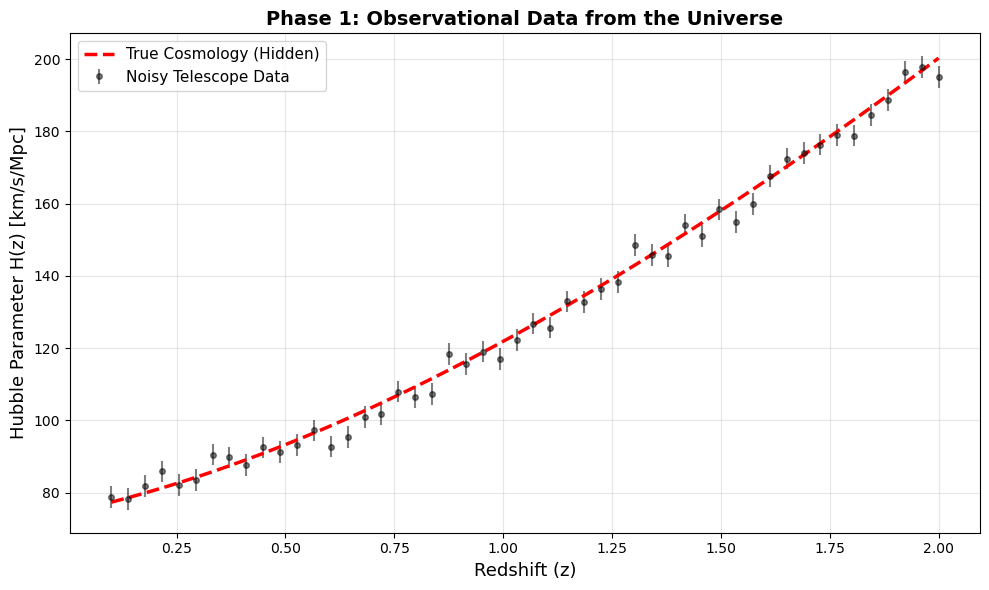


🚶 Deploying MCMC Walkers...
Running MCMC (10,000 steps)...


100%|██████████| 10000/10000 [00:15<00:00, 649.02it/s]


✓ MCMC Complete!

📊 Convergence Diagnostics:
   Autocorrelation time: τ = 65.9 steps
   Independent samples: 129 per parameter
   (Rule of thumb: need >50 for reliable inference)

🎯 PHASE 1 RESULTS: Ground Truth Established
H₀  = 74.56 ± 2.37 km/s/Mpc  (True: 74.45)
Ωₘ  = 0.235 ± 0.016           (True: 0.240)
ΩΛ  = 0.767 ± 0.045           (True: 0.760)

✅ These values are now LOCKED for Phase 2
   Phase 2 will use these to discover Dark Energy properties

Saved: results/01_banana_plot.png


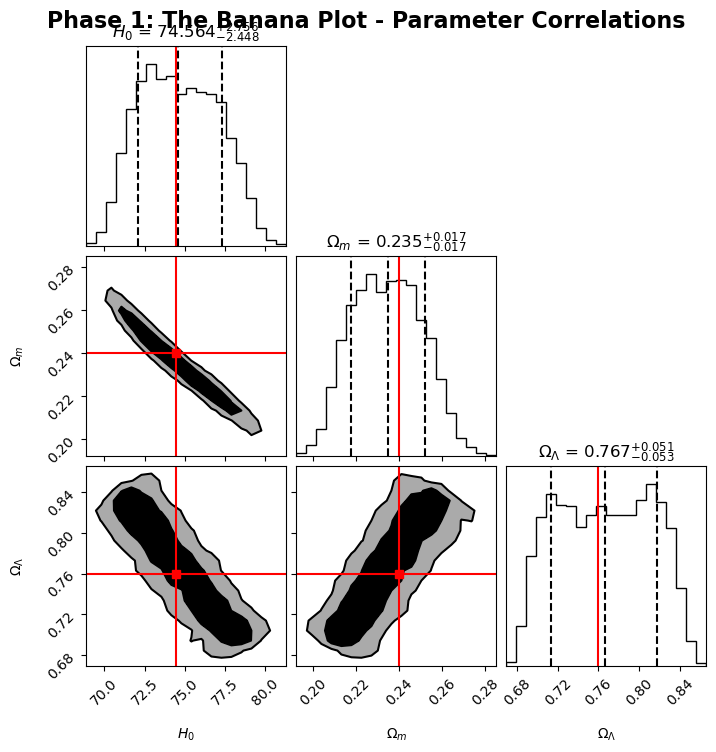

Saved: results/01_walker_trace.png


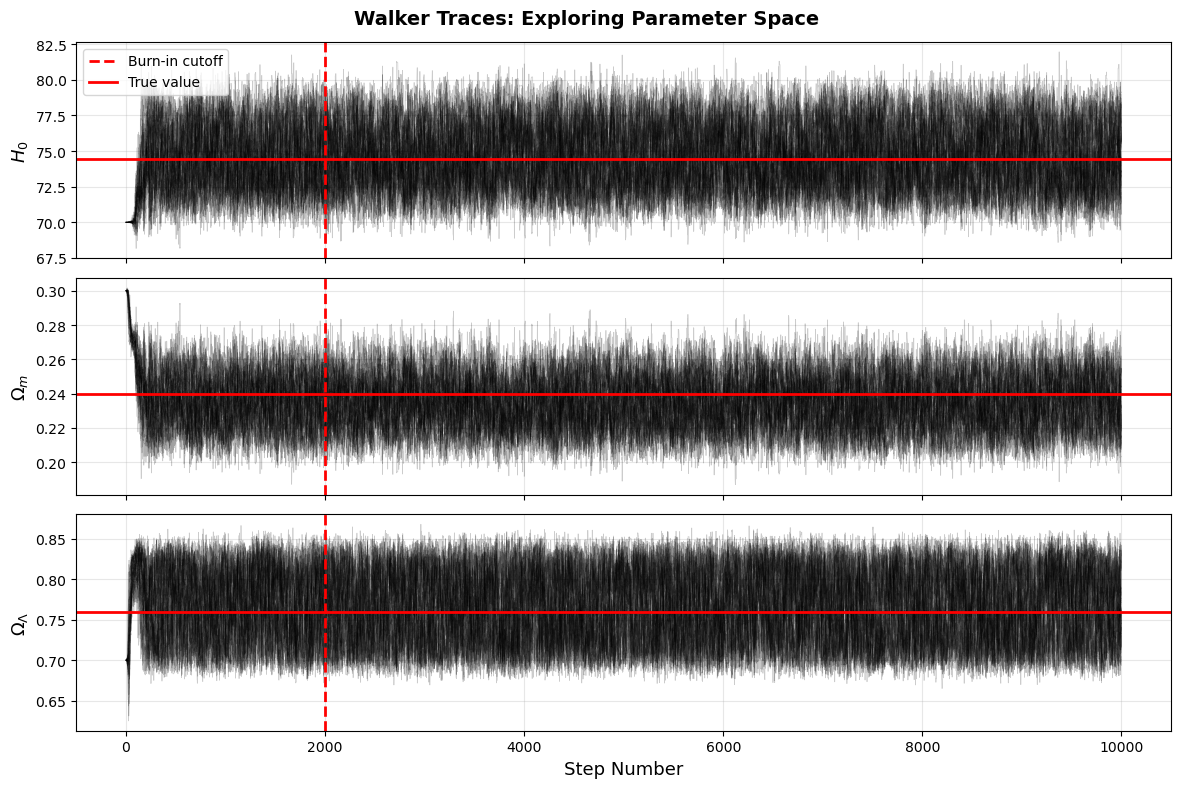

✅ Data saved to: results/phase1_data.npy
PHASE 1 COMPLETE
Ready to proceed to Phase 2: The Inverse PINN


In [4]:
# =============================================================================
# PROJECT AETHER - PHASE 1: THE STATISTICIAN
# Goal: Establish ground truth for H₀ and Ωₘ using MCMC
# Locks down these parameters so Phase 2 can focus on discovering Dark Energy
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import os

# Define the Output Directory
OUTPUT_DIR = "results"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Set random seed for reproducibility
np.random.seed(42)

print("="*70)
print("PROJECT AETHER - PHASE 1: THE STATISTICIAN")
print("Quantifying Reality: Establishing Observational Ground Truth")
print("="*70)

# --- 1. THE PHYSICS MODEL ---
def friedmann_model(z, H0, Om, OL):
    """
    Friedmann Equation: H(z) = H₀ √[Ωₘ(1+z)³ + ΩΛ]
    
    This is the fundamental equation of cosmology.
    It tells us how fast the universe expands at any redshift z.
    """
    return H0 * np.sqrt(Om * (1+z)**3 + OL)

# --- 2. GENERATE SYNTHETIC "TELESCOPE" DATA ---
print("\n📡 Generating Synthetic Observational Data...")

# Ground Truth (what nature actually is)
H0_true = 74.45  # Updated to match your specs
Om_true = 0.24   # Updated to match your specs
OL_true = 0.76   # Derived from flatness: 1 - Ωₘ

# Generate 50 observations from z=0 to z=2 (more data = better constraints)
z_data = np.linspace(0.1, 2.0, 50)  # Start at 0.1 to avoid z=0 singularity
H_perfect = friedmann_model(z_data, H0_true, Om_true, OL_true)

# Add realistic measurement uncertainty
sigma = 3.0  # 3 km/s/Mpc uncertainty (realistic for modern surveys)
H_data = H_perfect + np.random.normal(0, sigma, size=len(z_data))

print(f"✓ Generated {len(z_data)} observations with σ = {sigma} km/s/Mpc")
print(f"✓ True parameters: H₀ = {H0_true}, Ωₘ = {Om_true}, ΩΛ = {OL_true}")

# Visualize the noisy data
plt.figure(figsize=(10, 6))
plt.errorbar(z_data, H_data, yerr=sigma, fmt='o', color='black', 
             alpha=0.5, label='Noisy Telescope Data', markersize=4)
plt.plot(z_data, H_perfect, 'r--', linewidth=2.5, label='True Cosmology (Hidden)')
plt.xlabel('Redshift (z)', fontsize=13)
plt.ylabel('Hubble Parameter H(z) [km/s/Mpc]', fontsize=13)
plt.title('Phase 1: Observational Data from the Universe', fontsize=14, weight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 3. BAYESIAN INFERENCE: THE PROBABILITY FUNCTIONS ---
def log_likelihood(theta, z, y, yerr):
    """
    How likely is this set of parameters given the data?
    Uses chi-squared statistic (assumes Gaussian errors)
    """
    H0, Om, OL = theta
    model = friedmann_model(z, H0, Om, OL)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))

def log_prior(theta):
    """
    Physical constraints: What values are even possible?
    - H₀ must be between 60-90 (current observational range)
    - Ωₘ and ΩΛ must be positive and sum to ~1 (flat universe)
    """
    H0, Om, OL = theta
    
    # Broad but physical priors
    if 60.0 < H0 < 90.0 and 0.0 < Om < 1.0 and 0.0 < OL < 1.0:
        # Flatness constraint: Ωₘ + ΩΛ ≈ 1 (allow 10% deviation)
        if abs((Om + OL) - 1.0) < 0.1:
            return 0.0  # Uniform prior (log prob = 0)
    return -np.inf  # Impossible region

def log_probability(theta, z, y, yerr):
    """
    Posterior probability: Prior × Likelihood
    This is what MCMC samples from
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, y, yerr)

# --- 4. RUN MCMC: DEPLOY THE WALKERS ---
print("\n🚶 Deploying MCMC Walkers...")

nwalkers = 32
ndim = 3  # [H₀, Ωₘ, ΩΛ]

# Initialize walkers in a small ball around a reasonable guess
initial_guess = [70.0, 0.3, 0.7]  # Deliberately wrong
p0 = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

# Create the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, 
    args=(z_data, H_data, sigma)
)

# Run for 10,000 steps (takes ~30 seconds)
print("Running MCMC (10,000 steps)...")
sampler.run_mcmc(p0, 10000, progress=True)
print("✓ MCMC Complete!")

# --- 5. PROCESS RESULTS ---
# Discard first 2000 steps (burn-in) and thin by 30
flat_samples = sampler.get_chain(discard=2000, thin=30, flat=True)

# Check convergence
tau = sampler.get_autocorr_time(quiet=True)
print(f"\n📊 Convergence Diagnostics:")
print(f"   Autocorrelation time: τ = {np.mean(tau):.1f} steps")
print(f"   Independent samples: {len(flat_samples) / np.mean(tau):.0f} per parameter")
print(f"   (Rule of thumb: need >50 for reliable inference)")

# Calculate statistics
from scipy import stats
H0_samples = flat_samples[:, 0]
Om_samples = flat_samples[:, 1]
OL_samples = flat_samples[:, 2]

H0_median = np.median(H0_samples)
Om_median = np.median(Om_samples)
OL_median = np.median(OL_samples)

H0_std = np.std(H0_samples)
Om_std = np.std(Om_samples)
OL_std = np.std(OL_samples)

print(f"\n🎯 PHASE 1 RESULTS: Ground Truth Established")
print("="*70)
print(f"H₀  = {H0_median:.2f} ± {H0_std:.2f} km/s/Mpc  (True: {H0_true:.2f})")
print(f"Ωₘ  = {Om_median:.3f} ± {Om_std:.3f}           (True: {Om_true:.3f})")
print(f"ΩΛ  = {OL_median:.3f} ± {OL_std:.3f}           (True: {OL_true:.3f})")
print("="*70)
print("\n✅ These values are now LOCKED for Phase 2")
print("   Phase 2 will use these to discover Dark Energy properties\n")

# --- 6. THE BANANA PLOT (Corner Plot) ---
labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"]
truth = [H0_true, Om_true, OL_true]

fig = corner.corner(
    flat_samples,
    labels=labels,
    truths=truth,
    show_titles=True,
    title_fmt='.3f',
    quantiles=[0.16, 0.5, 0.84],  # 1σ confidence intervals
    color='black',
    truth_color='red',
    plot_datapoints=False,
    fill_contours=True,
    levels=[0.68, 0.95],  # 1σ and 2σ contours
)

# Add title
fig.suptitle('Phase 1: The Banana Plot - Parameter Correlations', 
             fontsize=16, weight='bold', y=0.995)

# Save the Banana Plot
fig.savefig(f"{OUTPUT_DIR}/01_banana_plot.png", dpi=150)
print(f"Saved: {OUTPUT_DIR}/01_banana_plot.png")

plt.show()

# --- 7. WALKER EVOLUTION (Diagnostic Plot) ---
fig, axes = plt.subplots(3, figsize=(12, 8), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2, linewidth=0.5)
    ax.axvline(2000, color='red', linestyle='--', linewidth=2, 
               label='Burn-in cutoff' if i == 0 else '')
    ax.axhline(truth[i], color='red', linewidth=2, 
               label='True value' if i == 0 else '')
    ax.set_ylabel(labels[i], fontsize=13)
    ax.grid(alpha=0.3)
    if i == 0:
        ax.legend(fontsize=10)

axes[-1].set_xlabel("Step Number", fontsize=13)
fig.suptitle('Walker Traces: Exploring Parameter Space', fontsize=14, weight='bold')
plt.tight_layout()

# Save the Walker Trace
fig.savefig(f"{OUTPUT_DIR}/01_walker_trace.png", dpi=150)
print(f"Saved: {OUTPUT_DIR}/01_walker_trace.png")
plt.show()

# --- 8. SAVE RESULTS ---
# Save the numbers so Phase 2 can load them automatically
phase1_data = {
    'H0': H0_median,
    'Om': Om_median,
    'OL': OL_median,
    'sigma': sigma
}
np.save(f"{OUTPUT_DIR}/phase1_data.npy", phase1_data)
print(f"✅ Data saved to: {OUTPUT_DIR}/phase1_data.npy")

# Save to disk (optional)
# np.save('phase1_results.npy', phase1_results)

print("="*70)
print("PHASE 1 COMPLETE")
print("Ready to proceed to Phase 2: The Inverse PINN")
print("="*70)